<a href="https://www.kaggle.com/code/chandlertimm/pan-cancer-nuclei-inference?scriptVersionId=95228284" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn
import cv2
import torch

from PIL import Image
from tqdm import tqdm

# For Hover-Net

## Set-Up Configuration for Inference

In [2]:
!git clone https://github.com/vqdang/hover_net.git
%cd hover_net

Cloning into 'hover_net'...
remote: Enumerating objects: 2024, done.
remote: Counting objects: 100% (253/253), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 2024 (delta 126), reused 221 (delta 116), pack-reused 1771
Receiving objects: 100% (2024/2024), 40.42 MiB | 10.08 MiB/s, done.
Resolving deltas: 100% (1230/1230), done.
/kaggle/working/hover_net


In [3]:
%%writefile dataset.py

import glob
import cv2
import numpy as np
import scipy.io as sio


class __AbstractDataset(object):
    """Abstract class for interface of subsequent classes.
    Main idea is to encapsulate how each dataset should parse
    their images and annotations.
    
    """

    def load_img(self, path):
        raise NotImplementedError

    def load_ann(self, path, with_type=False):
        raise NotImplementedError


####
class __PanNuke(__AbstractDataset):

    def load_img(self, path):
        return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

    def load_ann(self, path, with_type=False):
        # assumes that ann is HxW
        assert not with_type, "Not support"
        ann_inst = sio.loadmat(path)["inst_map"]
        ann_inst = ann_inst.astype("int32")
        ann = np.expand_dims(ann_inst, -1)
        return ann


####
def get_dataset(name):
    """Return a pre-defined dataset object associated with `name`."""
    name_dict = {
        "pannuke": lambda: __PanNuke(),
    }
    if name.lower() in name_dict:
        return name_dict[name]()
    else:
        assert False, "Unknown dataset `%s`" % name

Overwriting dataset.py


In [4]:
%%writefile config.py

import importlib
import random

import cv2
import numpy as np

from dataset import get_dataset


class Config(object):
    """Configuration file."""

    def __init__(self):
        self.seed = 10

        self.logging = True

        # turn on debug flag to trace some parallel processing problems more easily
        self.debug = False

        model_name = "hovernet"
        model_mode = "fast" # choose either `original` or `fast`

        if model_mode not in ["original", "fast"]:
            raise Exception("Must use either `original` or `fast` as model mode")

        nr_type = 6 # number of nuclear types (including background)

        # whether to predict the nuclear type, availability depending on dataset!
        self.type_classification = True

        # shape information - 
        # below config is for original mode. 
        # If original model mode is used, use [270,270] and [80,80] for act_shape and out_shape respectively
        # If fast model mode is used, use [256,256] and [164,164] for act_shape and out_shape respectively
        aug_shape = [540, 540] # patch shape used during augmentation (larger patch may have less border artefacts)
        act_shape = [256,256] # patch shape used as input to network - central crop performed after augmentation
        out_shape = [164,164] # patch shape at output of network

        if model_mode == "original":
            if act_shape != [270,270] or out_shape != [80,80]:
                raise Exception("If using `original` mode, input shape must be [270,270] and output shape must be [80,80]")
        if model_mode == "fast":
            if act_shape != [256,256] or out_shape != [164,164]:
                raise Exception("If using `fast` mode, input shape must be [256,256] and output shape must be [164,164]")

        self.dataset_name = "pannuke" # extracts dataset info from dataset.py
        self.log_dir = "checkpoint/" # where checkpoints will be saved

        # paths to training and validation patches
        self.train_dir_list = [
            "train/"
        ]
        self.valid_dir_list = [
            "val/"
        ]

        self.shape_info = {
            "train": {"input_shape": act_shape, "mask_shape": out_shape,},
            "valid": {"input_shape": act_shape, "mask_shape": out_shape,},
        }

        # * parsing config to the running state and set up associated variables
        self.dataset = get_dataset(self.dataset_name)

        module = importlib.import_module(
            "models.%s.opt" % model_name
        )
        self.model_config = module.get_config(nr_type, model_mode)

Overwriting config.py


## Set-up environment

In [5]:
!conda env create -f environment.yml
!conda activate hovernet
!pip install torch==1.6.0 torchvision==0.7.0

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.5
  latest version: 4.12.0

Please update conda by running

    $ conda update -n base conda



libdeflate-1.10      | 77 KB     | ##################################### | 100% 
libffi-3.3           | 51 KB     | ##################################### | 100% 
zstd-1.5.2           | 458 KB    | ##################################### | 100% 
libuuid-2.32.1       | 28 KB     | ##################################### | 100% 
libpng-1.6.37        | 306 KB  

## Start Inference Method

In [6]:
%%writefile models/hovernet/opt.py

import torch.optim as optim

from run_utils.callbacks.base import (
    AccumulateRawOutput,
    PeriodicSaver,
    ProcessAccumulatedRawOutput,
    ScalarMovingAverage,
    ScheduleLr,
    TrackLr,
    VisualizeOutput,
    TriggerEngine,
)
from run_utils.callbacks.logging import LoggingEpochOutput, LoggingGradient
from run_utils.engine import Events

from .targets import gen_targets, prep_sample
from .net_desc import create_model
from .run_desc import proc_valid_step_output, train_step, valid_step, viz_step_output


# TODO: training config only ?
# TODO: switch all to function name String for all option
def get_config(nr_type, mode):
    return {
        # ------------------------------------------------------------------
        # ! All phases have the same number of run engine
        # phases are run sequentially from index 0 to N
        "phase_list": [
            {
                "run_info": {
                    # may need more dynamic for each network
                    "net": {
                        "desc": lambda: create_model(
                            input_ch=3, nr_types=nr_type, 
                            freeze=True, mode=mode
                        ),
                        "optimizer": [
                            optim.Adam,
                            {  # should match keyword for parameters within the optimizer
                                "lr": 0.0025,  # initial learning rate,
                                "betas": (0.9, 0.999),
                            },
                        ],
                        # learning rate scheduler
                        "lr_scheduler": lambda x: optim.lr_scheduler.MultiStepLR(x, milestones=[8,11]),
                        "extra_info": {
                            "loss": {
                                "np": {"bce": 1, "dice": 1},
                                "hv": {"mse": 1, "msge": 1},
                                "tp": {"bce": 1, "dice": 1},
                            },
                        },
                        # path to load, -1 to auto load checkpoint from previous phase,
                        # None to start from scratch
                        "pretrained": "../../input/preactresnet50-weights/ImageNet-ResNet50-Preact_pytorch.tar",
                        # 'pretrained': None,
                    },
                },
                "target_info": {"gen": (gen_targets, {}), "viz": (prep_sample, {})},
                "batch_size": {"train": 2, "valid": 2,},  # engine name : value
                "nr_epochs": 12,
            },
            {
                "run_info": {
                    # may need more dynamic for each network
                    "net": {
                        "desc": lambda: create_model(
                            input_ch=3, nr_types=nr_type, 
                            freeze=False, mode=mode
                        ),
                        "optimizer": [
                            optim.Adam,
                            {  # should match keyword for parameters within the optimizer
                                "lr": 0.0025,  # initial learning rate,
                                "betas": (0.9, 0.999),
                            },
                        ],
                        # learning rate scheduler
                        "lr_scheduler": lambda x: optim.lr_scheduler.MultiStepLR(x, milestones=[8,11]),
                        "extra_info": {
                            "loss": {
                                "np": {"bce": 1, "dice": 1},
                                "hv": {"mse": 1, "msge": 1},
                                "tp": {"bce": 1, "dice": 1},
                            },
                        },
                        # path to load, -1 to auto load checkpoint from previous phase,
                        # None to start from scratch
                        "pretrained": -1,
                    },
                },
                "target_info": {"gen": (gen_targets, {}), "viz": (prep_sample, {})},
                "batch_size": {"train": 2, "valid": 2,}, # batch size per gpu
                "nr_epochs": 12,
            },
        ],
        # ------------------------------------------------------------------
        # TODO: dynamically for dataset plugin selection and processing also?
        # all enclosed engine shares the same neural networks
        # as the on at the outer calling it
        "run_engine": {
            "train": {
                # TODO: align here, file path or what? what about CV?
                "dataset": "",  # whats about compound dataset ?
                "nr_procs": 16,  # number of threads for dataloader
                "run_step": train_step,  # TODO: function name or function variable ?
                "reset_per_run": False,
                # callbacks are run according to the list order of the event
                "callbacks": {
                    Events.STEP_COMPLETED: [
                        # LoggingGradient(), # TODO: very slow, may be due to back forth of tensor/numpy ?
                        ScalarMovingAverage(),
                    ],
                    Events.EPOCH_COMPLETED: [
                        TrackLr(),
                        PeriodicSaver(),
                        VisualizeOutput(viz_step_output),
                        LoggingEpochOutput(),
                        TriggerEngine("valid"),
                        ScheduleLr(),
                    ],
                },
            },
            "valid": {
                "dataset": "",  # whats about compound dataset ?
                "nr_procs": 8,  # number of threads for dataloader
                "run_step": valid_step,
                "reset_per_run": True,  # * to stop aggregating output etc. from last run
                # callbacks are run according to the list order of the event
                "callbacks": {
                    Events.STEP_COMPLETED: [AccumulateRawOutput(),],
                    Events.EPOCH_COMPLETED: [
                        # TODO: is there way to preload these ?
                        ProcessAccumulatedRawOutput(
                            lambda a: proc_valid_step_output(a, nr_types=nr_type)
                        ),
                        LoggingEpochOutput(),
                    ],
                },
            },
        },
    }

Overwriting models/hovernet/opt.py


In [7]:
%%writefile models/hovernet/targets.py

import math
import numpy as np

import torch
import torch.nn.functional as F

from scipy import ndimage
from scipy.ndimage import measurements
from skimage import morphology as morph
import matplotlib.pyplot as plt

from misc.utils import center_pad_to_shape, cropping_center, get_bounding_box
from dataloader.augs import fix_mirror_padding


####
def gen_instance_hv_map(ann, crop_shape):
    """Input annotation must be of original shape.
    
    The map is calculated only for instances within the crop portion
    but based on the original shape in original image.

    Perform following operation:
    Obtain the horizontal and vertical distance maps for each
    nuclear instance.

    """
    orig_ann = ann.copy()  # instance ID map
    fixed_ann = fix_mirror_padding(orig_ann)
    # re-cropping with fixed instance id map
    crop_ann = cropping_center(fixed_ann, crop_shape)
    # TODO: deal with 1 label warning
    crop_ann = morph.remove_small_objects(crop_ann, min_size=30)

    x_map = np.zeros(orig_ann.shape[:2], dtype=np.float32)
    y_map = np.zeros(orig_ann.shape[:2], dtype=np.float32)

    inst_list = list(np.unique(crop_ann))
    inst_list.remove(0)  # 0 is background
    for inst_id in inst_list:
        inst_map = np.array(fixed_ann == inst_id, np.uint8)
        inst_box = get_bounding_box(inst_map)

        # expand the box by 2px
        # Because we first pad the ann at line 207, the bboxes
        # will remain valid after expansion
        inst_box[0] -= 2
        inst_box[2] -= 2
        inst_box[1] += 2
        inst_box[3] += 2

        inst_map = inst_map[inst_box[0] : inst_box[1], inst_box[2] : inst_box[3]]

        if inst_map.shape[0] < 2 or inst_map.shape[1] < 2:
            continue

        # instance center of mass, rounded to nearest pixel
        inst_com = list(measurements.center_of_mass(inst_map))

        inst_com[0] = int(inst_com[0] + 0.5)
        inst_com[1] = int(inst_com[1] + 0.5)

        inst_x_range = np.arange(1, inst_map.shape[1] + 1)
        inst_y_range = np.arange(1, inst_map.shape[0] + 1)
        # shifting center of pixels grid to instance center of mass
        inst_x_range -= inst_com[1]
        inst_y_range -= inst_com[0]

        inst_x, inst_y = np.meshgrid(inst_x_range, inst_y_range)

        # remove coord outside of instance
        inst_x[inst_map == 0] = 0
        inst_y[inst_map == 0] = 0
        inst_x = inst_x.astype("float32")
        inst_y = inst_y.astype("float32")

        # normalize min into -1 scale
        if np.min(inst_x) < 0:
            inst_x[inst_x < 0] /= -np.amin(inst_x[inst_x < 0])
        if np.min(inst_y) < 0:
            inst_y[inst_y < 0] /= -np.amin(inst_y[inst_y < 0])
        # normalize max into +1 scale
        if np.max(inst_x) > 0:
            inst_x[inst_x > 0] /= np.amax(inst_x[inst_x > 0])
        if np.max(inst_y) > 0:
            inst_y[inst_y > 0] /= np.amax(inst_y[inst_y > 0])

        ####
        x_map_box = x_map[inst_box[0] : inst_box[1], inst_box[2] : inst_box[3]]
        x_map_box[inst_map > 0] = inst_x[inst_map > 0]

        y_map_box = y_map[inst_box[0] : inst_box[1], inst_box[2] : inst_box[3]]
        y_map_box[inst_map > 0] = inst_y[inst_map > 0]

    hv_map = np.dstack([x_map, y_map])
    return hv_map


####
def gen_targets(ann, crop_shape, **kwargs):
    """Generate the targets for the network."""
    hv_map = gen_instance_hv_map(ann, crop_shape)
    np_map = ann.copy()
    np_map[np_map > 0] = 1

    hv_map = cropping_center(hv_map, crop_shape)
    np_map = cropping_center(np_map, crop_shape)

    target_dict = {
        "hv_map": hv_map,
        "np_map": np_map,
    }

    return target_dict


####
def prep_sample(data, is_batch=False, **kwargs):
    """
    Designed to process direct output from loader
    """
    cmap = plt.get_cmap("jet")

    def colorize(ch, vmin, vmax, shape):
        ch = np.squeeze(ch.astype("float32"))
        ch = ch / (vmax - vmin + 1.0e-16)
        # take RGB from RGBA heat map
        ch_cmap = (cmap(ch)[..., :3] * 255).astype("uint8")
        ch_cmap = center_pad_to_shape(ch_cmap, shape)
        return ch_cmap

    def prep_one_sample(data):
        shape_array = [np.array(v.shape[:2]) for v in data.values()]
        
#         for v in data.values():
#             print(np.array(v.shape[:2]))
#             raise ValueError("debugging")
#         print(shape_array)
#         print(max(shape_array, key=lambda x:np.max(x)))
#         raise ValueError("debugging")
        
        shape = max(shape_array, key=lambda x:np.max(x))
        viz_list = []
        viz_list.append(colorize(data["np_map"], 0, 1, shape))
        # map to [0,2] for better visualisation.
        # Note, [-1,1] is used for training.
        viz_list.append(colorize(data["hv_map"][..., 0] + 1, 0, 2, shape))
        viz_list.append(colorize(data["hv_map"][..., 1] + 1, 0, 2, shape))
        img = center_pad_to_shape(data["img"], shape)
        return np.concatenate([img] + viz_list, axis=1)

    # cmap may randomly fails if of other types
    if is_batch:
        viz_list = []
        data_shape = list(data.values())[0].shape
        for batch_idx in range(data_shape[0]):
            sub_data = {k : v[batch_idx] for k, v in data.items()}
            viz_list.append(prep_one_sample(sub_data))
        return np.concatenate(viz_list, axis=0)
    else:
        return prep_one_sample(data)

Overwriting models/hovernet/targets.py


In [8]:
if not os.path.isdir('../hover-net'):
    os.mkdir('../hover-net/')
    os.mkdir('../hover-net/infer_tiles/')
    os.mkdir('../hover-net/infer_tiles/imgs/')
    os.mkdir('../hover-net/infer_tiles/pred/')

In [9]:
!cp -r ../../input/pan-cancer-nuclei-instance-segmentation-1/hover_net/checkpoint .././hover-net

In [10]:
!cp -r ../../input/pancancer-nuclei-data-analysis/pan-cancer-nuclei-data-analysis/images/101.jpeg .././hover-net/infer_tiles/imgs/
!cp -r ../../input/pancancer-nuclei-data-analysis/pan-cancer-nuclei-data-analysis/images/105.jpeg .././hover-net/infer_tiles/imgs/
!cp -r ../../input/pancancer-nuclei-data-analysis/pan-cancer-nuclei-data-analysis/images/106.jpeg .././hover-net/infer_tiles/imgs/
!cp -r ../../input/pancancer-nuclei-data-analysis/pan-cancer-nuclei-data-analysis/images/1003.jpeg .././hover-net/infer_tiles/imgs/
!cp -r ../../input/pancancer-nuclei-data-analysis/pan-cancer-nuclei-data-analysis/images/1037.jpeg .././hover-net/infer_tiles/imgs/
!cp -r ../../input/pancancer-nuclei-data-analysis/pan-cancer-nuclei-data-analysis/images/1056.jpeg .././hover-net/infer_tiles/imgs/

In [11]:
!python run_infer.py \
--gpu='0' \
--nr_types=6 \
--type_info_path=type_info.json \
--batch_size=1 \
--model_mode=fast \
--model_path=../hover-net/checkpoint/01/net_epoch=12.tar \
--nr_inference_workers=1 \
--nr_post_proc_workers=1 \
tile \
--input_dir=../hover-net/infer_tiles/imgs/ \
--output_dir=../hover-net/infer_tiles/pred/ \
--mem_usage=0.1 \
--draw_dot \
--save_qupath

Process Patches:  96%|########################9 | 24/25 [00:03<00:00,  6.47it/s]


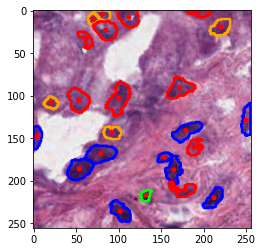

In [12]:
import matplotlib.pyplot as plt
#trying it out on a sample image
img = cv2.imread('../hover-net/infer_tiles/pred/overlay/1056.png')

img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

plt.figure(figsize=(4,4))
plt.imshow(img)

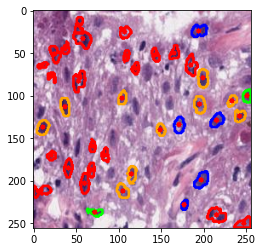

In [13]:
img = cv2.imread('../hover-net/infer_tiles/pred/overlay/1037.png')

img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

plt.figure(figsize=(4,4))
plt.imshow(img)

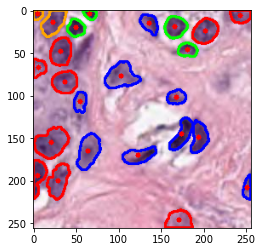

In [14]:
img = cv2.imread('../hover-net/infer_tiles/pred/overlay/105.png')

img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

plt.figure(figsize=(4,4))
plt.imshow(img)

In [15]:
%cd ../
!rm -r ./hover_net

/kaggle/working


# For Mask-RCNN

## Install MMDetection

In [16]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

# Check Pytorch installation
import torch
print(torch.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

1.6.0


In [17]:
!python -m pip install --upgrade pip

     |████████████████████████████████| 2.1 MB 290 kB/s 
  Attempting uninstall: pip
    Found existing installation: pip 20.2.3
    Uninstalling pip-20.2.3:
      Successfully uninstalled pip-20.2.3


In [18]:
!pip install openmim --use-feature=2020-resolver
!mim install mmdet

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -r requirements/build.txt 
!pip install -v -e . 

  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 KB 377.8 kB/s eta 0:00:00
  Created wheel for openmim: filename=openmim-0.1.5-py2.py3-none-any.whl size=42502 sha256=681149cb163fb3917e9cd07bc539bfa652ca5aadd0d0c3232f7780841bc59bb0
  Stored in directory: /root/.cache/pip/wheels/16/8b/e1/bdebbbc687aa50224a5ce46fe97a040a0c59f92b34bfc750b6
Successfully built openmim
  Attempting uninstall: Click
    Found existing installation: click 7.1.1
    Uninstalling click-7.1.1:
      Successfully uninstalled click-7.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-xgboost 0.1.11 requires xgboost<=0.90, but you have xgboost 1.2.0 which is incompatible.
installing mmdet from https://github.com/open-mmlab/mmdetection.git.
Cloning into '/tmp/tmpxpt29x_2/mmdetection'...
remote: Enumerating objects: 24362, done.
remote: C

In [19]:
# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

2.24.1
10.1
GCC 7.3


## Register PanNuke as new dataset

In [20]:
#parse the order of categories in the json file
import json

with open('../../input/pannuke-coco/train.json', 'r') as json_file:
    json_load = json.load(json_file)

CLASSES = []
for i in range(5):
    #print(json_load['categories'][i]['name'])
    CLASSES.append(json_load['categories'][i]['name'])

print(CLASSES)

['neoplastic', 'inflammatory', 'softtissue', 'dead', 'epithelial']


In [21]:
# where the checkpoints will be saved
if not os.path.isdir('.././mask-rcnn'):
    os.makedirs('.././mask-rcnn/work_dirs')

In [22]:
!cp -r ../../input/pan-cancer-nuclei-instance-segmentation-2/mmdetection/work_dirs/epoch_36.pth .././mask-rcnn/work_dirs/

In [23]:
from mmcv import Config
cfg = Config.fromfile('./configs/mask_rcnn/mask_rcnn_r50_fpn_1x_coco.py')

In [24]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'COCODataset'

# Modify dataset type and path
cfg.data_root = '../../input/pannuke-coco'

cfg.data.train.classes = (CLASSES[0], CLASSES[1], CLASSES[2], CLASSES[3], CLASSES[4])
cfg.data.train.ann_file = cfg.data_root + '/train.json'
cfg.data.train.img_prefix = cfg.data_root + '/train/'

cfg.data.val.classes = (CLASSES[0], CLASSES[1], CLASSES[2], CLASSES[3], CLASSES[4])
cfg.data.val.ann_file = cfg.data_root + '/val.json'
cfg.data.val.img_prefix = cfg.data_root + '/val/'

cfg.data.test.classes = (CLASSES[0], CLASSES[1], CLASSES[2], CLASSES[3], CLASSES[4])
cfg.data.test.ann_file = cfg.data_root + '/val.json'
cfg.data.test.img_prefix = cfg.data_root + '/val/'

# modify num classes of the model in box head and mask head
cfg.model.roi_head.bbox_head.num_classes = 5
cfg.model.roi_head.mask_head.num_classes = 5

# If we need to finetune a model based on a pre-trained detector
# cfg.resume_from = '.././mask-rcnn/work_dirs/epoch_36.pth'
# cfg.load_from = '.././mask-rcnn/work_dirs/epoch_36.pth'

#set the working directory
cfg.work_dir = '.././mask-rcnn/work_dirs'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 50

# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 1
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

cfg.lr_config = dict(
    policy='step',
    warmup='linear',
    warmup_iters=500,
    warmup_ratio=0.001,
    step=[8, 11, 20, 23, 32, 35])

cfg.runner = dict(type='EpochBasedRunner', max_epochs=36)

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device = 'cuda'

# set different configs for every data
cfg_train = cfg
cfg_test = cfg
cfg_inference = cfg

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='MaskRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_wei

## Inference Method

In [25]:
if not os.path.isdir('.././mask-rcnn/work_dirs/imgs'):
    os.makedirs('.././mask-rcnn/work_dirs/imgs')
    
    !cp -r ../../input/pancancer-nuclei-data-analysis/pan-cancer-nuclei-data-analysis/images/101.jpeg .././mask-rcnn/work_dirs/imgs
    !cp -r ../../input/pancancer-nuclei-data-analysis/pan-cancer-nuclei-data-analysis/images/105.jpeg .././mask-rcnn/work_dirs/imgs
    !cp -r ../../input/pancancer-nuclei-data-analysis/pan-cancer-nuclei-data-analysis/images/106.jpeg .././mask-rcnn/work_dirs/imgs
    !cp -r ../../input/pancancer-nuclei-data-analysis/pan-cancer-nuclei-data-analysis/images/1003.jpeg .././mask-rcnn/work_dirs/imgs
    !cp -r ../../input/pancancer-nuclei-data-analysis/pan-cancer-nuclei-data-analysis/images/1037.jpeg .././mask-rcnn/work_dirs/imgs
    !cp -r ../../input/pancancer-nuclei-data-analysis/pan-cancer-nuclei-data-analysis/images/1056.jpeg .././mask-rcnn/work_dirs/imgs

In [26]:
import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector


# Setup a checkpoint file to load
checkpoint = '.././mask-rcnn/work_dirs/epoch_36.pth'

# Set the device to be used for evaluation
device='cuda:0'

# Load the config
config = cfg_inference
# Set pretrained to be None since we do not need pretrained model here
config.model.pretrained = None

# Initialize the detector
model = build_detector(config.model)

# Load checkpoint
checkpoint = load_checkpoint(model, checkpoint, map_location=device)

# Set the classes of models for inference
model.CLASSES = checkpoint['meta']['CLASSES']

# We need to set the model's cfg for inference
model.cfg = config

# Convert the model to GPU
model.to(device)
# Convert the model into evaluation mode
model.eval();

load checkpoint from local path: .././mask-rcnn/work_dirs/epoch_36.pth


/kaggle/working/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


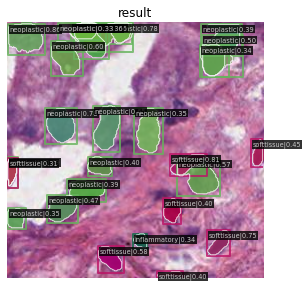

In [27]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv

img = mmcv.imread('.././mask-rcnn/work_dirs/imgs/1056.jpeg')

result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.3)

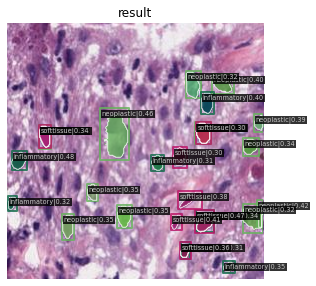

In [28]:
img = mmcv.imread('.././mask-rcnn/work_dirs/imgs/1037.jpeg')

result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.3)

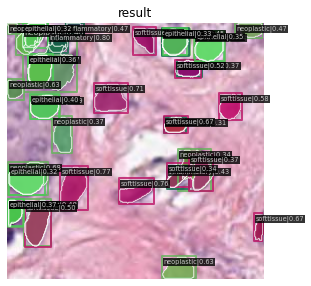

In [29]:
img = mmcv.imread('.././mask-rcnn/work_dirs/imgs/105.jpeg')

result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.3)

In [30]:
%cd ..
!rm -r mmdetection

/kaggle/working
